# Autonekoder na datasecie SWaT

### Wczytanie danych

In [1]:
import pandas as pd
import numpy as np

df_test = pd.read_csv('SWaT_Dataset_Attack_v0.csv', sep=';', decimal=',', low_memory=False)
df_train = pd.read_csv('SWaT_Dataset_Normal_v1.csv', decimal=',')

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Usunięcie kolumny timestamp
if 'Timestamp' in df_train.columns:
    df_train = df_train.drop(columns=['Timestamp'])
if 'Timestamp' in df_test.columns:
    df_test = df_test.drop(columns=['Timestamp'])

# Usuwamy kolumnę z etykietami
if 'Normal/Attack' in df_train.columns:
    df_train = df_train.drop(columns=['Normal/Attack'])

test_labels = df_test.iloc[:, -1].values  
if 'Normal/Attack' in df_test.columns:
    df_test = df_test.drop(columns=['Normal/Attack'])

# Normalizacja danych
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(df_train)
test_data_scaled = scaler.transform(df_test)

In [3]:
import numpy as np

def create_windows(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

### Definicja modelu

In [4]:
import torch
from torch import nn, optim

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 10),

        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 50),
            nn.ReLU(),
            nn.Linear(50, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

GPU is available :)


In [15]:
from torch.utils.data import DataLoader, TensorDataset

window_size = 400
step_size = 100
epochs = 100
batch_size = 64
learning_rate = 0.001

train_windows = create_windows(train_data_scaled, window_size, step_size)

X_train_windows = train_windows.reshape(train_windows.shape[0], -1)
X_train_tensor = torch.tensor(X_train_windows, dtype=torch.float32).to(device)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = X_train_tensor.shape[1]
model = AE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")



Epoch 1/100, Loss: 0.073948
Epoch 2/100, Loss: 0.024684
Epoch 3/100, Loss: 0.015757
Epoch 4/100, Loss: 0.012190
Epoch 5/100, Loss: 0.010698
Epoch 6/100, Loss: 0.009518
Epoch 7/100, Loss: 0.008351
Epoch 8/100, Loss: 0.007376
Epoch 9/100, Loss: 0.006852
Epoch 10/100, Loss: 0.006604
Epoch 11/100, Loss: 0.006373
Epoch 12/100, Loss: 0.006220
Epoch 13/100, Loss: 0.006049
Epoch 14/100, Loss: 0.005921
Epoch 15/100, Loss: 0.005804
Epoch 16/100, Loss: 0.005692
Epoch 17/100, Loss: 0.005622
Epoch 18/100, Loss: 0.005525
Epoch 19/100, Loss: 0.005373
Epoch 20/100, Loss: 0.005348
Epoch 21/100, Loss: 0.005291
Epoch 22/100, Loss: 0.005227
Epoch 23/100, Loss: 0.005120
Epoch 24/100, Loss: 0.005126
Epoch 25/100, Loss: 0.004988
Epoch 26/100, Loss: 0.004923
Epoch 27/100, Loss: 0.004912
Epoch 28/100, Loss: 0.004802
Epoch 29/100, Loss: 0.004781
Epoch 30/100, Loss: 0.004766
Epoch 31/100, Loss: 0.004779
Epoch 32/100, Loss: 0.004686
Epoch 33/100, Loss: 0.004598
Epoch 34/100, Loss: 0.004566
Epoch 35/100, Loss: 0.0

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_windows = create_windows(test_data_scaled, window_size, step_size)
X_test_windows = test_windows.reshape(test_windows.shape[0], -1)
X_test_tensor = torch.tensor(X_test_windows, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    train_recon = model(X_train_tensor)
    test_recon = model(X_test_tensor)

    train_loss = torch.mean((train_recon - X_train_tensor)**2, dim=1).cpu().numpy()
    test_loss = torch.mean((test_recon - X_test_tensor)**2, dim=1).cpu().numpy()

threshold = np.percentile(train_loss, 99)
print("Threshold for anomaly detection:", threshold)

# Jeśli choć jedna próbka w oknie jest "Attack", to całe okno jest "Attack"
y_test_windows = []
for i in range(len(test_windows)):
    window_labels = test_labels[i:i+window_size]
    y_test_windows.append(1 if "Attack" in window_labels else 0)
y_test_windows = np.array(y_test_windows)

y_pred = (test_loss > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_windows, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_windows, y_pred))

Threshold for anomaly detection: 0.019601919
Confusion Matrix:
[[1220 1120]
 [  59 2097]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.52      0.67      2340
           1       0.65      0.97      0.78      2156

    accuracy                           0.74      4496
   macro avg       0.80      0.75      0.73      4496
weighted avg       0.81      0.74      0.73      4496



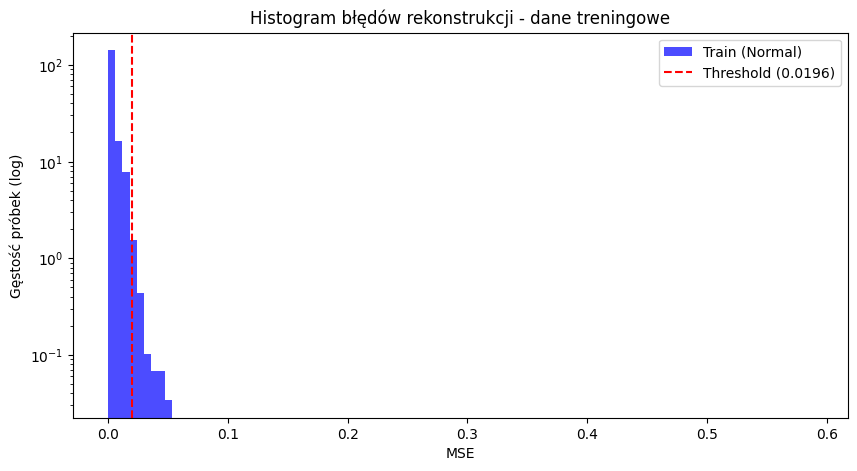

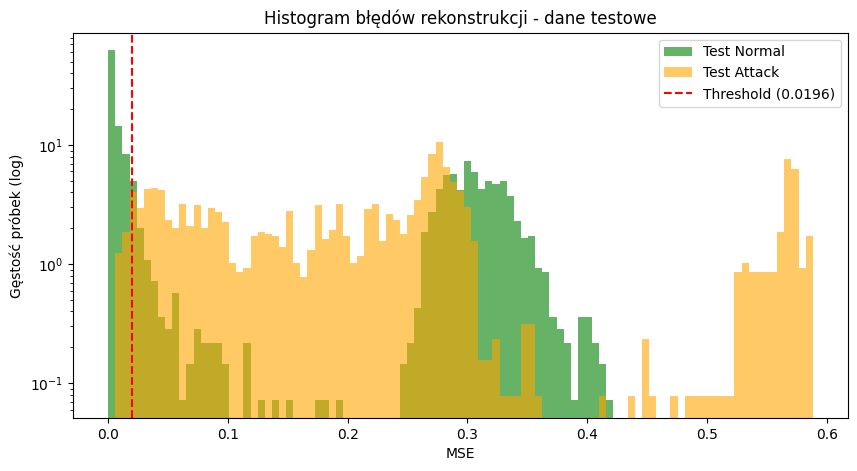

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Ustalamy wspólne biny na podstawie max wartości z obu zbiorów
bins = np.linspace(0, max(train_loss.max(), test_loss.max()), 100)

# Histogram błędów rekonstrukcji – dane treningowe
plt.figure(figsize=(10,5))
plt.hist(train_loss, bins=bins, alpha=0.7, color='blue',
         label='Train (Normal)', log=True, density=True)
plt.axvline(threshold, color='red', linestyle='--',
            label=f'Threshold ({threshold:.4f})')
plt.title('Histogram błędów rekonstrukcji - dane treningowe')
plt.xlabel('MSE')
plt.ylabel('Gęstość próbek (log)')
plt.legend()
plt.show()

# Histogram błędów rekonstrukcji – dane testowe
plt.figure(figsize=(10,5))
plt.hist(test_loss[y_test_windows==0], bins=bins, alpha=0.6, color='green',
         label='Test Normal', log=True, density=True)
plt.hist(test_loss[y_test_windows==1], bins=bins, alpha=0.6, color='orange',
         label='Test Attack', log=True, density=True)
plt.axvline(threshold, color='red', linestyle='--',
            label=f'Threshold ({threshold:.4f})')
plt.title('Histogram błędów rekonstrukcji - dane testowe')
plt.xlabel('MSE')
plt.ylabel('Gęstość próbek (log)')
plt.legend()
plt.show()
